In [1]:
from torch.utils.data import DataLoader, Dataset
from sklearn.metrics import accuracy_score
from torch.optim import Adam, lr_scheduler
from torchvision import transforms as T
import torchvision.models as models
import matplotlib.pyplot as plt
import os
from os.path import join
from glob import glob
from PIL import Image
from torch import nn
import pandas as pd
import numpy as np
import torchvision
import torch
from sklearn import svm
import random
import tarfile
import io
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")
import encoding
from sklearn.manifold import TSNE

In [2]:
device = 'cuda:0'

In [4]:
train_df = pd.read_csv('/data/wikiart/wikiart_Painting100k/MultitaskPainting100k_Dataset_groundtruth/groundtruth_multiloss_train_header.csv')
valid_df = pd.read_csv('/data/wikiart/wikiart_Painting100k/MultitaskPainting100k_Dataset_groundtruth/groundtruth_multiloss_test_header.csv')

In [5]:
train_df['img_path'] = train_df.apply(lambda x: join('/data/wikiart/wikiart_Painting100k/images_256minside',x.filename),1)
valid_df['img_path'] = valid_df.apply(lambda x: join('/data/wikiart/wikiart_Painting100k/images_256minside',x.filename),1)

In [6]:
train_df = train_df.replace('wildlife painting', 'animal painting')
train_df = train_df.replace('self-portrait', 'portrait')
train_df = train_df.replace('poster', 'design')
train_df = train_df.replace('advertisement', 'illustration')
train_df = train_df.replace('cloudscape', 'landscape')
train_df = train_df.replace('literary painting', 'mythological painting')
train_df = train_df.replace('battle painting', 'history painting')
train_df = train_df.replace('bird-and-flower painting', 'animal painting')
train_df = train_df[train_df.genre.isin(['shan shui','panorama','miniature','pastorale','quadratura','vanitas','bijinga',
                                        'calligraphy','yakusha-e'])==False]

In [7]:
valid_df = valid_df.replace('wildlife painting', 'animal painting')
valid_df = valid_df.replace('self-portrait', 'portrait')
valid_df = valid_df.replace('poster', 'design')
valid_df = valid_df.replace('advertisement', 'illustration')
valid_df = valid_df.replace('cloudscape', 'landscape')
valid_df = valid_df.replace('literary painting', 'mythological painting')
valid_df = valid_df.replace('battle painting', 'history painting')
valid_df = valid_df.replace('bird-and-flower painting', 'animal painting')
valid_df = valid_df[valid_df.genre.isin(['shan shui','panorama','miniature','pastorale','quadratura','vanitas','bijinga',
                                        'calligraphy','yakusha-e'])==False]

#train_df=pd.read_pickle('/data/Notebook/train_df_db.pkl')

In [9]:
train_df.head()

,filename,artist,style,genre,img_path
0,102257.jpg,Barnett Newman,Color Field Painting,abstract,/data/wikiart/wikiart_Painting100k/images_256m...
1,29855.jpg,Tosa Mitsuoki,Yamato-e,mythological painting,/data/wikiart/wikiart_Painting100k/images_256m...
2,63861.jpg,Barnett Newman,Color Field Painting,abstract,/data/wikiart/wikiart_Painting100k/images_256m...
3,84512.jpg,Franz Richard Unterberger,Romanticism,cityscape,/data/wikiart/wikiart_Painting100k/images_256m...
4,53180.jpg,Hiroshige,Ukiyo-e,animal painting,/data/wikiart/wikiart_Painting100k/images_256m...


In [10]:
train_df.genre.value_counts()

portrait                 12648
landscape                10493
genre painting            9858
abstract                  6316
religious painting        5086
cityscape                 3734
sketch and study          2552
illustration              2229
still life                2161
symbolic painting         1686
mythological painting     1667
design                    1557
nude painting (nu)        1553
figurative                1501
animal painting           1360
marina                    1242
flower painting           1128
history painting           840
allegorical painting       707
interior                   487
capriccio                  169
veduta                     167
caricature                 142
tessellation               127
Name: genre, dtype: int64

In [12]:
class_dict_genre = {}
for i, genre in enumerate(np.sort(train_df.genre.unique())):
    train_df.loc[train_df.genre==genre, 'class_genre'] = i
    valid_df.loc[valid_df.genre==genre, 'class_genre'] = i
    class_dict_genre.update({i:genre})

In [13]:
dict_genre = {v: k for k, v in class_dict_genre.items()}

In [14]:
train_df

,filename,artist,style,genre,img_path,class_genre
0,102257.jpg,Barnett Newman,Color Field Painting,abstract,/data/wikiart/wikiart_Painting100k/images_256m...,0.0
1,29855.jpg,Tosa Mitsuoki,Yamato-e,mythological painting,/data/wikiart/wikiart_Painting100k/images_256m...,15.0
2,63861.jpg,Barnett Newman,Color Field Painting,abstract,/data/wikiart/wikiart_Painting100k/images_256m...,0.0
3,84512.jpg,Franz Richard Unterberger,Romanticism,cityscape,/data/wikiart/wikiart_Painting100k/images_256m...,5.0
4,53180.jpg,Hiroshige,Ukiyo-e,animal painting,/data/wikiart/wikiart_Painting100k/images_256m...,2.0
...,...,...,...,...,...,...
69816,9400.jpg,Clarence Holbrook Carter,Abstract Expressionism,abstract,/data/wikiart/wikiart_Painting100k/images_256m...,0.0
69817,21240.jpg,Cesar Domela,Concretism,abstract,/data/wikiart/wikiart_Painting100k/images_256m...,0.0
69818,17971.jpg,Pisanello,Early Renaissance,sketch and study,/data/wikiart/wikiart_Painting100k/images_256m...,19.0
69819,12758.jpg,Michelangelo,High Renaissance,nude painting (nu),/data/wikiart/wikiart_Painting100k/images_256m...,16.0


In [15]:
valid_df.genre.value_counts()

portrait                 5482
landscape                4518
genre painting           4239
abstract                 2756
religious painting       2168
cityscape                1575
sketch and study         1040
illustration              957
still life                913
mythological painting     764
symbolic painting         744
design                    695
nude painting (nu)        672
figurative                603
animal painting           594
marina                    534
flower painting           441
history painting          378
allegorical painting      311
interior                  174
caricature                 84
capriccio                  66
veduta                     66
tessellation               50
Name: genre, dtype: int64

In [16]:
train_transforms = T.Compose([
                                T.Resize(256), 
                                T.RandomResizedCrop(size=224, scale=(0.3,1), ratio=(1,1)),
                                T.RandomHorizontalFlip(p=0.5),
                                T.ToTensor(),
                                T.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])
                            ])

valid_transforms = T.Compose([
                                T.Resize(224), 
                                T.CenterCrop(224), 
                                T.ToTensor(),
                                T.Normalize(mean=[0.485, 0.456, 0.406], 
                                            std=[0.229, 0.224, 0.225])
                            ])

In [17]:
tr = T.Compose([
    T.Resize(256),
    T.RandomResizedCrop(size=224, scale=(0.3,1), ratio=(1,1)),
    T.RandomHorizontalFlip(p=0.5)
])

tr_v = T.Compose([
    T.Resize(224),
    T.CenterCrop(224)
])

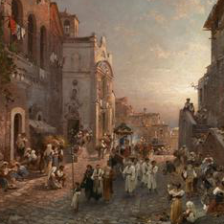

In [18]:
row = train_df.iloc[3]
tr(Image.open(row.img_path))

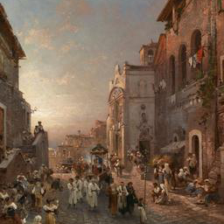

In [19]:
tr_v(Image.open(row.img_path))

In [20]:
print(row.genre)

cityscape


In [21]:
class ImageDataset(Dataset):
    
    def __init__(self, df, transform, sample=None):
        if sample: 
            self.df = df.groupby(by='genre').sample(sample)
        else:
            self.df = df
            
        self.transform = transform
        
    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        anc = self.df.iloc[idx]    
        pos = self.df[self.df.genre == anc.genre].sample(1).squeeze()
        neg = self.df[self.df.genre != anc.genre].sample(1).squeeze()
        anchor_class = int(anc.class_genre)
                
        anchorImg   = Image.open(anc.img_path).convert('RGB')
        positiveImg = Image.open(pos.img_path).convert('RGB')
        negativeImg = Image.open(neg.img_path).convert('RGB')
        return self.transform(anchorImg), self.transform(positiveImg), self.transform(negativeImg), anchor_class

In [40]:
batch_size = 8

train_loader = DataLoader(ImageDataset(train_df, train_transforms), 
                          batch_size=batch_size, shuffle=True, 
                          num_workers = 6, pin_memory=False, 
                          drop_last=False)

valid_loader = DataLoader(ImageDataset(valid_df, valid_transforms),#, sample=50),
                          batch_size=batch_size, pin_memory=False, 
                          num_workers = 6, drop_last=False)

In [41]:
def imshow(image):
    npimg = image.numpy().transpose(1, 2, 0)
    npimg = npimg/(npimg.max()-npimg.min())+0.5
    plt.imshow(npimg)
    plt.axis("off")
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


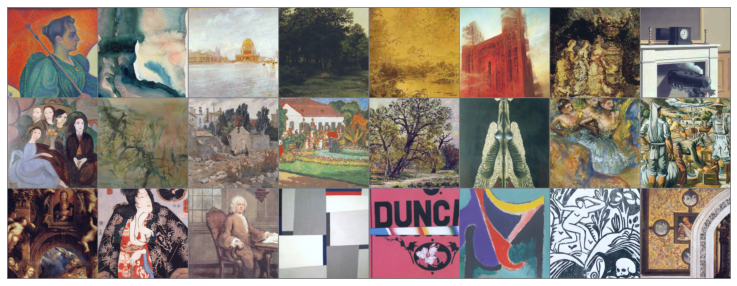

In [52]:
dataiter = iter(train_loader)
anchor, positive, negative,_ = dataiter.next()
concatenate = torch.cat((anchor, positive, negative), 0)

fig, ax = plt.subplots(1, figsize=(20, 5))
imshow(torchvision.utils.make_grid(concatenate, nrow=batch_size))

In [25]:
class Triplet_model(nn.Module):
    def __init__(self, base_model):
        super(Triplet_model, self).__init__()
        self.base = base_model
        self.fc = nn.Sequential( 
            nn.Linear(2048, 256),
            nn.PReLU(),
            nn.Dropout(0.6),
            nn.Linear(256, 128))
        
    def forward_once(self, x):
        return self.fc(self.base(x))
    
    def forward(self, input1, input2, input3):
        anchor = self.forward_once(input1)
        positive = self.forward_once(input2)
        negative = self.forward_once(input3)
        return anchor, positive, negative

In [26]:
base_model = models.resnet50(pretrained=True)
base_model.fc = nn.Identity()
model = Triplet_model(base_model).to(device)

In [27]:
import time
class Timer:
    def __init__(self):
        self._start_time = None
    def start(self):
        self._start_time = time.perf_counter()
    def stop(self):
        elapsed_time = time.perf_counter() - self._start_time
        return round(elapsed_time)

In [ ]:
def train(model, loss_func, device, train_loader, optimizer, epoch):
    t = Timer(); t.start()
    
    model.train()
    loss_list, acc_list = [], []
    
    for batch_idx, (anchor, positive, negative,_) in enumerate(train_loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        optimizer.zero_grad()
        
        out_anchor, out_positive, out_negative = model(anchor, positive, negative)
        loss = loss_func(out_anchor, out_positive, out_negative)
               
        loss.backward()
        optimizer.step()
        
        loss_list.append(loss.item())
        
        pdist = nn.PairwiseDistance(p=2)
        output_posit = pdist(out_anchor, out_positive)
        output_negat = pdist(out_anchor, out_negative)
        
        acc_list.append(output_posit < output_negat)
        acc = torch.cat(acc_list).detach().cpu().numpy().mean()
        
        template = "Train--> [{}:{:2.0f}] Iteration {} ({:3.1f}%): Loss = {:.4f} | Accuracy = {:.3f}\r"
        loss_arr = np.array(loss_list)
        #percentage = 100*(batch_idx+1)/maxiter if maxiter else 100*batch_idx/len(train_loader)
        percentage = 100*batch_idx/len(train_loader)
        stop_time = t.stop()
        print(template.format(round(stop_time/60), round(stop_time)%60, batch_idx, percentage, np.mean(loss_arr), acc), end='')
        if percentage == 100: break

    stop_time = t.stop()    
    print(template.format(round(stop_time/60), round(stop_time)%60, batch_idx, percentage, np.mean(loss_arr), acc))
    return model, np.mean(loss_arr), acc 

In [ ]:
def valid(model, loss_func, device, loader, epoch):
    t = Timer(); t.start()
    model.eval()
    loss_list, acc_list = [], []

    for batch_idx, (anchor, positive, negative,_) in enumerate(loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        out_anchor, out_positive, out_negative = model(anchor, positive, negative)
        loss = loss_func(out_anchor, out_positive, out_negative)
       
        loss_list.append(loss.item())
        
        pdist = nn.PairwiseDistance(p=2)
        output_posit = pdist(out_anchor, out_positive)
        output_negat = pdist(out_anchor, out_negative)
        
        acc_list.append(output_posit < output_negat)
        acc = torch.cat(acc_list).detach().cpu().numpy().mean()

        percentage = batch_idx/len(loader)
        print('Computing Validation ({:.1%})\r'.format(percentage), end='')
        if percentage == 1: break
       
    template = "Valid--> [{}:{:2.0f}] Iteration {}: Loss = {:.4f} | Accuracy = {:.3f}"
    loss_arr = np.array(loss_list)
    stop_time = t.stop()
    print(template.format(round(stop_time/60), round(stop_time)%60, batch_idx, np.mean(loss_arr), acc),)
    return np.mean(loss_arr), acc

In [28]:
lr = 1.e-5

#optimizer = torch.optim.Adam([{'params':model.base.parameters(), 'lr':1.e-5}, 
                              #{'params':model.fc.parameters(),  'lr':lr}], 
                             #lr=lr, weight_decay=1.e-4)
lr = 1.e-5       
optimizer = torch.optim.SGD([{'params':model.base.parameters(), 'lr':1.e-6},{'params':model.fc.parameters(),   'lr':lr}], lr=lr, momentum=0.9, weight_decay=0.0001)
criterion = nn.TripletMarginLoss(margin=1)
scheduler = torch.optim.lr_scheduler.MultiplicativeLR(optimizer, lr_lambda=lambda epoch: 0.98)

In [ ]:
def save_loss_fig(loss_train, loss_valid, accuracy_train, accuracy_valid, epoch):
    loss_train_df=pd.DataFrame(loss_train)
    loss_valid_df=pd.DataFrame(loss_valid)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,4))
    ax1.plot([i for i in range(len(loss_train))], loss_train, label='train_loss')
    ax1.plot([i for i in range(len(loss_valid))],  loss_valid, label='valid_loss')
    #ax1.plot([i for i in range(len(loss_train))], loss_train, linewidth=4, alpha=0.3)
    #ax1.plot([i for i in range(len(loss_valid))],  loss_valid,linewidth=4, alpha=0.3)
    #ax1.plot([i for i in range(len(loss_train))], loss_train_df[0].rolling(10).mean(), color='blue', label='train_loss')
    #ax1.plot([i for i in range(len(loss_valid))],  loss_valid_df[0].rolling(10).mean(), color='orange',  label='valid_loss')
    ax1.set(xlabel='epoch', ylabel='loss')
    ax1.legend()
    
    accuracy_train_df=pd.DataFrame(accuracy_train)
    accuracy_valid_df=pd.DataFrame(accuracy_valid)
    ax2.plot([i for i in range(len(accuracy_train))], accuracy_train, label='train_accuracy')
    ax2.plot([i for i in range(len(accuracy_valid))],  accuracy_valid, label='valid_accuracy')
    #ax2.plot([i for i in range(len(accuracy_train))], accuracy_train, linewidth=4, alpha=0.3)
    #ax2.plot([i for i in range(len(accuracy_valid))],  accuracy_valid, linewidth=4,alpha=0.3)
    #ax2.plot([i for i in range(len(accuracy_train))], accuracy_train_df[0].rolling(10).mean(), color='blue', label='train_accuracy')
    #ax2.plot([i for i in range(len(accuracy_valid))],  accuracy_valid_df[0].rolling(10).mean(), color='orange', label='valid_accuracy')
    ax2.set(xlabel='epoch', ylabel='accuracy')
    ax2.legend()
    fig.suptitle(f'EPOCH {epoch}', fontsize=16)
    plt.close(fig)
    fig.savefig(os.path.join('.', "loss_plot_genre_SGD.jpg"), pad_inches=0)

In [ ]:
train_df.genre.value_counts()

In [ ]:
train_loss_list, acc_train_list, valid_loss_list, acc_valid_list = [], [], [], []
for epoch in range(2000):
    if epoch == 0: valid_loss, acc_valid = valid(model, criterion, device, valid_loader, epoch) 

    train_loader = DataLoader(ImageDataset(train_df, train_transforms, sample=120),  
                          batch_size=batch_size, shuffle=True, 
                          num_workers = 8, pin_memory=False, 
                          drop_last=False)
        
    print('Epoch: {}'.format(epoch))
    for i in range(5):
        model, train_loss, acc_train = train(model, criterion, device, train_loader, optimizer, epoch)
    train_loss_list.append(train_loss)
    acc_train_list.append(acc_train)
    valid_loss, acc_valid = valid(model, criterion, device, valid_loader, epoch)
    valid_loss_list.append(valid_loss)
    acc_valid_list.append(acc_valid)
    
    torch.save(model, './triplet_genre_SGD.pt')
    
    save_loss_fig(train_loss_list, valid_loss_list, acc_train_list, acc_valid_list, epoch)

# T-sne

In [ ]:
def embedding_fwd(x):
    img = Image.open(x).convert('RGB')
    img = valid_transforms(img).unsqueeze(0).to(device)
    return model.forward_once(img).detach().cpu().numpy()[0]

In [ ]:
valid_df['embed'] = valid_df.img_path.apply(embedding_fwd)

In [ ]:
np.concatenate(valid_df['embed'].tolist(), axis=0).reshape(-1,128)

In [ ]:
X_train = np.concatenate(valid_df['embed'].tolist(), axis=0).reshape(-1,128)

In [ ]:
y_train=valid_df['class_genre'].to_numpy().reshape(-1,1)

In [ ]:
tsne = TSNE(n_components=2, perplexity=50) #try different perplexity
X_embedded = tsne.fit_transform(X_train)

In [ ]:
valid_df.head()

In [ ]:
fig=plt.figure(figsize=(20, 20))
plt.title('t-SNE genre')
    
color = ['dimgrey','lightgray','rosybrown','indianred','brown','red','tomato','darksalmon','sienna','b',
            'darkorange','burlywood','darkgoldenrod','gold','olive','yellow','olivedrab','yellowgreen','lawngreen','darkseagreen',
             'palegreen','green','lime','mediumaquamarine']#,'aquamarine','turquoise','darkslategrey','teal','aqua','deepskyblue',
            # 'dodgerblue','cornflowerblue','royalblue','midnightblue','blue','slateblue','darkslateblue','rebeccapurple','blueviolet','purple','fuchsia']
    
for label, c in zip(np.unique(y_train), color):
    plt.scatter(X_embedded[y_train.reshape(-1) == label, 0], 
                X_embedded[y_train.reshape(-1) == label, 1],
                c=c,
                #cmap=plt.cm.Set1(label / float(len(np.unique(y_train)))),
                #marker='.',
                linewidth='1',
                alpha=0.8,
                label=class_dict_genre[label])
plt.legend(loc='best')
plt.close(fig)
fig.savefig(os.path.join('.', "tsne_plot_genre.jpg"), pad_inches=0)

In [ ]:
fig = plt.figure(figsize=(15,5))
rows = 1
columns = 2

fig.add_subplot(rows, columns, 1)
plt.plot([i for i in range(len(train_loss_list))], train_loss_list, label='train_loss')
plt.plot([i for i in range(len(valid_loss_list))], valid_loss_list, label='valid_loss')
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

fig.add_subplot(rows, columns, 2)
plt.plot([i for i in range(len(train_acc_list))], train_acc_list, label='train_acc')
plt.plot([i for i in range(len(valid_acc_list))], valid_acc_list, label='valid_acc')
plt.xlabel("epoch")
plt.ylabel("Accuracy")
plt.legend()

# Classifier

In [29]:
def train_classifier(model, loss_func, device, loader, clf): 
    t = Timer(); t.start()
    model.eval()
    loss_list, X, y = [], [], []

    for batch_idx, (anchor, positive, negative, anchor_class) in enumerate(loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        out_anchor, out_positive, out_negative = model(anchor, positive, negative)
        loss = loss_func(out_anchor, out_positive, out_negative)
       
        loss_list.append(loss.item())
        
        X.append(out_anchor.detach().cpu().numpy())
        y.append(anchor_class.detach().cpu().numpy())

        #percentage = (batch_idx+1)/maxiter if maxiter else batch_idx/len(loader)
        percentage = batch_idx/len(loader)
        print('Training SVM classifier ({:.1%})\r'.format(percentage), end='')
        if percentage == 1: break
    
    clf.fit(np.concatenate(X), np.concatenate(y).reshape(-1))
    pred = clf.predict(np.concatenate(X))
    acc  =  accuracy_score(np.concatenate(y).reshape(-1), pred)

    template = "Train--> [{}:{}] Iteration {}: Loss = {:.4f} | Accuracy = {:.3f}"
    loss_arr = np.array(loss_list)
    stop_time = t.stop()
    print(template.format(round(stop_time/60), round(stop_time)%60, batch_idx, np.mean(loss_arr), acc),)
    return np.mean(loss_arr), acc, clf, X, y

In [50]:
def testing(model, loss_func, device, loader, clf):
    t = Timer(); t.start()
    model.eval()
    loss_list, X, y = [], [], []

    for batch_idx, (anchor, positive, negative, anchor_class) in enumerate(loader):
        anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
        
        
        out_anchor, out_positive, out_negative = model(anchor, positive, negative)
        loss = loss_func(out_anchor, out_positive, out_negative)
       
        loss_list.append(loss.item())

        
        X.append(out_anchor.detach().cpu().numpy())
        y.append(anchor_class.detach().cpu().numpy())

        percentage =  batch_idx/len(loader)
        print('Testing SVM classifier ({:.1%})\r'.format(percentage), end='')
        if percentage == 1: break
    
    pred = clf.predict(np.concatenate(X))
    acc  =  accuracy_score(np.concatenate(y).reshape(-1), pred)

    template = "Test--> [{}:{}] Iteration {}: Loss = {:.4f} | Acuracy = {:.3f}"
    loss_arr = np.array(loss_list)
    stop_time = t.stop()
    print(template.format(round(stop_time/60), round(stop_time)%60, batch_idx, np.mean(loss_arr), acc),)
    return np.mean(loss_arr), acc, pred, np.concatenate(y), np.concatenate(X)

## Testing

In [31]:
model = torch.load('/data/Notebook/triplets/triplet_genre.pt').to(device)

In [35]:
from sklearn.neighbors import KNeighborsClassifier

In [32]:
clf = svm.SVC(kernel='rbf',probability=True)
train_loss, train_accuracy, classifier, X_train, y_train = train_classifier(model, criterion, device, train_loader, clf)

Train--> [44:19] Iteration 8676: Loss = 0.5736 | Accuracy = 0.589


In [36]:
clf = KNeighborsClassifier(n_neighbors=3, n_jobs=-1)
train_loss, train_accuracy, classifier, X_train, y_train = train_classifier(model, criterion, device, train_loader, clf)

Train--> [10:14] Iteration 8676: Loss = 0.5751 | Accuracy = 0.680


In [37]:
print(f'Train accuracy: {round(train_accuracy*100,1)}%')

Train accuracy: 68.0%


In [51]:
test_loss, test_accuracy, y_pred, y_true, X_test = testing(model, criterion, device, valid_loader, classifier)
print(f'Valid accuracy: {round(test_accuracy*100,1)}%')

Test--> [4:16] Iteration 3727: Loss = 0.5636 | Acuracy = 0.502
Valid accuracy: 50.2%


In [ ]:
for i in range(10):
    concatenated = torch.cat((torch.from_numpy(X_train[i]), torch.from_numpy(X_train[i+1])), 0)
    distance = torch.nn.PairwiseDistance(torch.from_numpy(X_train[i]), torch.from_numpy(X_train[i+1]))
    fig, ax = plt.subplots(1, figsize=(20, 5))
    imshow(torchvision.utils.make_grid(concatenated.reshape(-1,128)))
    #dist = distance(torch.from_numpy(X_train[i]), torch.from_numpy(X_train[i+1]))
    print('Dissimilarity: {:.2f}'.format(dist.item()))
    print(f'Genre1: {class_dict_genre[y_train[i].item()]}, Genre2: {class_dict_genre[y_train[i+1].item()]}')

## t-SNE with images

In [ ]:
from matplotlib.offsetbox import OffsetImage, AnnotationBbox

In [ ]:
def save_tse_images(X):
    tsne = TSNE(n_components=2, perplexity=50) #try different perplexity (between 5 and 50)
    X_embedded = tsne.fit_transform(X)
    
    fig, ax = plt.subplots(figsize=(40,40))
    plt.title('t-SNE')
    artists = []
    
    for xy, i in zip (X_embedded, X):
        x0,y0 =xy
        img = OffsetImage(i, zoom=0.6)
        ab = AnnotationBbox(img, (x0, y0), xycoords='data', frameon=False)
        artists.append(ax.add_artist(ab))
    ax.update_datalim(X_embedded)
    ax.autoscale()
    
    #plt.close(fig)
    fig.savefig(os.path.join('.', "tsne_plot_images.jpg"), pad_inches=0)

In [ ]:
save_tse_images(X_test)

In [ ]:
#prova

def show_tse_images(X):
    tsne = TSNE(n_components=2, perplexity=50) #try different perplexity (between 5 and 50)
    X_embedded = tsne.fit_transform(X)
    tx, ty = tsne[:,0], tsne[:,1]
    tx = (tx-np.min(tx)) / (np.max(tx) - np.min(tx))
    ty = (ty-np.min(ty)) / (np.max(ty) - np.min(ty))
    width = 4000
    height = 3000
    max_dim = 100

    full_image = Image.new('RGB', (width, height))
    for img, x, y in zip(X, tx, ty):
        rs = max(1, img.width/max_dim, img.height/max_dim)
        img = img.resize((int(img.width/rs), int(img.height/rs)), Image.ANTIALIAS)
        full_image.paste(img, (int((width-max_dim)*x), int((height-max_dim)*y)), mask=img.convert('RGB'))

    matplotlib.pyplot.figure(figsize = (16,12))
    imshow(full_image)

In [ ]:
show_tse_image(X_test)

transform = T.Compose([
        T.Resize(224, 224),
        T.ToTensor(),
        T.Normalize(mean=[0.485, 0.456, 0.406], 
                    std=[0.229, 0.224, 0.225])])

inv_normalize = transforms.Normalize(
    mean=[-0.485/0.229, -0.456/0.224, -0.406/0.255],
    std=[1/0.229, 1/0.224, 1/0.255]
)

In [ ]:
def saliency(anchor, positive, negative, model):
    #we don't need gradients w.r.t. weights for a trained model
    for param in model.parameters():
        param.requires_grad = False
    
    model.eval()
    #transform input PIL image to torch.Tensor and normalize

    #we want to calculate gradient of higest score w.r.t. input
    #so set requires_grad to True for input 
    anchor.requires_grad = True
    #forward pass to calculate predictions
    anchor, positive, negative = anchor.to(device), positive.to(device), negative.to(device)
    out_anchor, _, _ = model(anchor, positive, negative)
    preds = clf.predict(out_anchor.detach().cpu().numpy())
    #preds = model(input)
    score, indices = torch.max(preds, 1)
    #backward pass to get gradients of score predicted class w.r.t. input image
    score.backward()
    #get max along channel axis
    slc, _ = torch.max(torch.abs(anchor.grad[0]), dim=0)
    #normalize to [0..1]
    slc = (slc - slc.min())/(slc.max()-slc.min())
    
    #apply inverse transform on image
    #with torch.no_grad():
    #    anchor_img = inv_normalize(anchor[0])
    #plot image and its saleincy map
    plt.figure(figsize=(10, 10))
    plt.subplot(1, 2, 1)
    plt.imshow(anchor.detach().numpy())
    plt.xticks([])
    plt.yticks([])
    plt.subplot(1, 2, 2)
    plt.imshow(slc.numpy(), cmap=plt.cm.hot)
    plt.xticks([])
    plt.yticks([])
    plt.show()

In [ ]:
validiter = iter(valid_loader)
anch, pos, neg, genre = validiter.next()

In [ ]:
#im = valid_df.iloc[1]
#img = Image.open(im.img_path).convert('RGB')
saliency(anch[0], pos[0], neg[0], model)